In [1]:
import json
import re
from collections import Counter, defaultdict
import unicodedata

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

12.4
True
NVIDIA GeForce RTX 3060 Ti


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chivalry\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
train_claims_path = 'data_cleaned/train-claims.json'
dev_claims_path = 'data_cleaned/dev-claims.json'
evidence_path = 'data_cleaned/evidence.json'
test_claims_path = 'data_cleaned/test-claims-unlabelled.json'

# loading the data
with open(train_claims_path, 'r', encoding='utf-8') as f:
    train_claims = json.load(f)
with open(dev_claims_path, 'r', encoding='utf-8') as f:
    dev_claims = json.load(f)
with open(evidence_path, 'r', encoding='utf-8') as f:
    evidences = json.load(f)
with open(test_claims_path, 'r', encoding='utf-8') as f:
    test_claims = json.load(f)

print(f"Loaded {len(train_claims)} training claims.")
print(f"Loaded {len(dev_claims)} dev claims.")
print(f"Loaded {len(evidences)} evidences.")
print(f"Loaded {len(test_claims)} test claims.")

Loaded 1228 training claims.
Loaded 154 dev claims.
Loaded 1208827 evidences.
Loaded 153 test claims.


In [ ]:
def build_inverted_index(evidence_dict, stopwords=set()):
    """
    Build:
    1. inverted index: word -> set of evidence IDs
    2. word sets for each evidence (not just cleaned text)
    """
    inverted_index = {}
    word_sets = {}

    for eid, text in evidence_dict.items():
        word_set = set(text.split())
        word_set = {w for w in word_set if w not in stopwords}
        word_sets[eid] = word_set
        for word in word_set:
            inverted_index.setdefault(word, set()).add(eid)

    return inverted_index, word_sets

def simple_retrieve_fast(claim_text, inverted_index, evidence_word_sets, top_k=5, max_candidates=1000, stopwords=set()):
    """
    Fast retrieval using inverted index + keyword match prioritization.

    Args:
        claim_text (str): The claim text.
        inverted_index (dict): Word -> set of evidence IDs.
        evidence_word_sets (dict): Evidence ID -> set of words.
        top_k (int): Number of final evidence IDs to return.
        max_candidates (int): Maximum number of evidence candidates to consider.

    Returns:
        List of evidence IDs.
    """
    claim_word_set = set(claim_text.split())
    claim_word_set = {w for w in claim_word_set if w not in stopwords}

    # Step 1: Collect candidate evidence IDs via keyword hit
    hit_counts = {}  # evidence_id -> hit count
    for word in claim_word_set:
        for eid in inverted_index.get(word, []):
            hit_counts[eid] = hit_counts.get(eid, 0) + 1

    # Step 2: Sort candidates by keyword hit count (desc)
    sorted_candidates = sorted(hit_counts.items(), key=lambda x: x[1], reverse=True)

    # Step 3: Limit to max_candidates
    candidate_ids = [eid for eid, count in sorted_candidates[:max_candidates]]

    # Step 4: Fine-grained overlap score (actual word intersection)
    scores = []
    for evidence_id in candidate_ids:
        evidence_words = evidence_word_sets[evidence_id]
        common_word_count = len(claim_word_set & evidence_words)
        scores.append((evidence_id, common_word_count))

    scores.sort(key=lambda x: x[1], reverse=True)
    top_evidence_ids = [evidence_id for evidence_id, score in scores[:top_k]]

    return top_evidence_ids

In [12]:
english_stopwords = set(stopwords.words('english'))
inverted_index, evidence_word_sets = build_inverted_index(evidences, stopwords=english_stopwords)
print("Inverted index and evidence word sets built.")
print(f"Number of unique words in inverted index: {len(inverted_index)}")
print(f"Number of unique evidence IDs: {len(evidence_word_sets)}")

Inverted index and evidence word sets built.
Number of unique words in inverted index: 543752
Number of unique evidence IDs: 1208827


In [18]:
claim_id = list(train_claims)[0]
print(f"Example claim ID: {claim_id}")
claim_text = train_claims[claim_id]["claim_text"]
print(f"Example claim text: {claim_text}")
print("============================================")
retrieved_evidence_ids = simple_retrieve_fast(claim_text, inverted_index, evidence_word_sets, top_k=5, max_candidates=100000, stopwords=english_stopwords)
print(f"Retrieved evidence IDs: {retrieved_evidence_ids}")
print(f"Retrieved evidence texts: {[evidences[evidence_id] for evidence_id in retrieved_evidence_ids]}")
print("============================================")
print(f"Correct evidence IDs: {train_claims[claim_id]['evidences']}")
print(f"Correct evidence texts: {[evidences[evidence_id] for evidence_id in train_claims[claim_id]['evidences']]}")

Example claim ID: claim-1937
Example claim text: not only be there no scientific evidence that co2 be a pollutant high co2 concentration actually help ecosystem support more plant and animal life
Retrieved evidence IDs: ['evidence-588973', 'evidence-55991', 'evidence-442946', 'evidence-202201', 'evidence-179375']
Retrieved evidence texts: ['the whitebark pine ecosystem in these high elevation play many essential role provide support to plant and animal life', 'on july 21 2011 while a guest on the show he state to suggest that co2 s a pollutant when it s an extremely important gas in the atmosphere for all plant life and therefore for the oxygen that s produce be just nonsense', 'at very high concentration 100 time atmospheric concentration or great carbon dioxide can be toxic to animal life so raise the concentration to 10 000 ppm 1 or high for several hour will eliminate pest such as whitefly and spider mite in a greenhouse', 'in terrestrial ecosystem the early timing of spring event 

In [ ]:
def get_retrieved_predictions_dict(
    claims,
    inverted_index,
    evidence_word_sets,
    top_k=5,
    max_candidates=1000
):
    """
    Generate a predictions dict from claims using simple_retrieve_fast()

    Returns:
        dict[str, list[str]]: claim_id -> list of predicted evidence IDs
    """
    predictions = {}

    for claim_id, claim_data in claims.items():
        claim_text = claim_data["claim_text"]

        predicted_evidences = simple_retrieve_fast(
            claim_text,
            inverted_index,
            evidence_word_sets,
            top_k=top_k,
            max_candidates=max_candidates,
            stopwords=english_stopwords
        )

        predictions[claim_id] = predicted_evidences

    return predictions

def evaluate_retrieval(predictions, gold_claims, top_k=5):
    """
    Evaluate retrieval performance using precision/recall/f1@k.

    Args:
        predictions: dict[str, list[str]] — claim_id -> predicted evidence ids
        gold_claims: dict[str, dict] — claim_id -> {"evidences": [...]}
        top_k: how many predicted evidences to evaluate

    Returns:
        precision, recall, f1
    """
    total_precision = 0
    total_recall = 0
    total_f1 = 0
    count = 0

    for claim_id, gold_data in gold_claims.items():
        gold_evidence_set = set(gold_data.get("evidences", []))
        predicted_evidence_set = set(predictions.get(claim_id, [])[:top_k])

        if not gold_evidence_set:
            continue  # skip if no gold evidence

        true_positives = predicted_evidence_set & gold_evidence_set
        num_true = len(true_positives)
        precision = num_true / len(predicted_evidence_set) if predicted_evidence_set else 0
        recall = num_true / len(gold_evidence_set) if gold_evidence_set else 0
        f1 = (2 * precision * recall) / (precision + recall) if precision + recall > 0 else 0

        total_precision += precision
        total_recall += recall
        total_f1 += f1
        count += 1

    if count == 0:
        return 0.0, 0.0, 0.0

    avg_precision = total_precision / count
    avg_recall = total_recall / count
    avg_f1 = total_f1 / count

    print(f"✅ Evaluated on {count} claims")
    print(f"Precision@{top_k}: {avg_precision:.4f}")
    print(f"Recall@{top_k}:    {avg_recall:.4f}")
    print(f"F1@{top_k}:        {avg_f1:.4f}")

    return avg_precision, avg_recall, avg_f1

In [15]:
retrieved_predictions = get_retrieved_predictions_dict(
    claims=train_claims,
    inverted_index=inverted_index,
    evidence_word_sets=evidence_word_sets,
    top_k=5,
    max_candidates=100000
)

evaluate_retrieval(retrieved_predictions, train_claims, top_k=5)

✅ Evaluated on 1228 claims
Precision@5: 0.0803
Recall@5:    0.1352
F1@5:        0.0947


(0.08029315960912099, 0.13521986970684047, 0.09466806266480565)

In [ ]:
retrieved_predictions = get_retrieved_predictions_dict(
    claims=dev_claims,
    inverted_index=inverted_index,
    evidence_word_sets=evidence_word_sets,
    top_k=5,
    max_candidates=100000
)
evaluate_retrieval(retrieved_predictions, dev_claims, top_k=5)

✅ Evaluated on 154 claims
Precision@5: 0.0883
Recall@5:    0.1587
F1@5:        0.1053


(0.08831168831168826, 0.15865800865800858, 0.10529272314986601)

In [21]:
import matplotlib.pyplot as plt

def sweep_top_k_evaluation(claims, inverted_index, evidence_word_sets, max_candidates=1000, k_range=range(3, 8)):
    """
    Sweep different values of top_k to evaluate retrieval performance.

    Args:
        claims: dict of claim_id -> {"claim_text", "evidences"}
        inverted_index: word -> set of evidence IDs
        evidence_word_sets: evidence ID -> set of words
        max_candidates: max evidence candidates to consider for each claim
        k_range: iterable of top_k values to test (e.g. range(3, 8))

    Returns:
        dict with lists: {"top_k": [...], "precision": [...], "recall": [...], "f1": [...]}
    """
    results = {
        "top_k": [],
        "precision": [],
        "recall": [],
        "f1": []
    }

    for k in k_range:
        print(f"🔍 Evaluating top_k={k} ...")
        predictions = get_retrieved_predictions_dict(
            claims=claims,
            inverted_index=inverted_index,
            evidence_word_sets=evidence_word_sets,
            top_k=k,
            max_candidates=max_candidates,
        )
        precision, recall, f1 = evaluate_retrieval(predictions, claims, top_k=k)
        results["top_k"].append(k)
        results["precision"].append(precision)
        results["recall"].append(recall)
        results["f1"].append(f1)

    return results

def plot_sweep_results(results):
    plt.figure(figsize=(10, 6))
    plt.plot(results["top_k"], results["precision"], marker='o', label="Precision@k")
    plt.plot(results["top_k"], results["recall"], marker='o', label="Recall@k")
    plt.plot(results["top_k"], results["f1"], marker='o', label="F1@k")
    plt.xlabel("Top-K")
    plt.ylabel("Score")
    plt.title("Retrieval Performance vs. Top-K")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


🔍 Evaluating top_k=3 ...
✅ Evaluated on 154 claims
Precision@3: 0.1190
Recall@3:    0.1341
F1@3:        0.1150
🔍 Evaluating top_k=4 ...
✅ Evaluated on 154 claims
Precision@4: 0.0990
Recall@4:    0.1438
F1@4:        0.1076
🔍 Evaluating top_k=5 ...
✅ Evaluated on 154 claims
Precision@5: 0.0883
Recall@5:    0.1587
F1@5:        0.1053
🔍 Evaluating top_k=6 ...
✅ Evaluated on 154 claims
Precision@6: 0.0801
Recall@6:    0.1715
F1@6:        0.1021
🔍 Evaluating top_k=7 ...
✅ Evaluated on 154 claims
Precision@7: 0.0714
Recall@7:    0.1763
F1@7:        0.0955
{'top_k': [3, 4, 5, 6, 7], 'precision': [0.11904761904761907, 0.09902597402597403, 0.08831168831168826, 0.08008658008658004, 0.07142857142857141], 'recall': [0.13409090909090904, 0.14383116883116878, 0.15865800865800858, 0.1715367965367965, 0.17629870129870123], 'f1': [0.11498144712430428, 0.10757060399917544, 0.10529272314986601, 0.10210874983602254, 0.09554965236783414]}


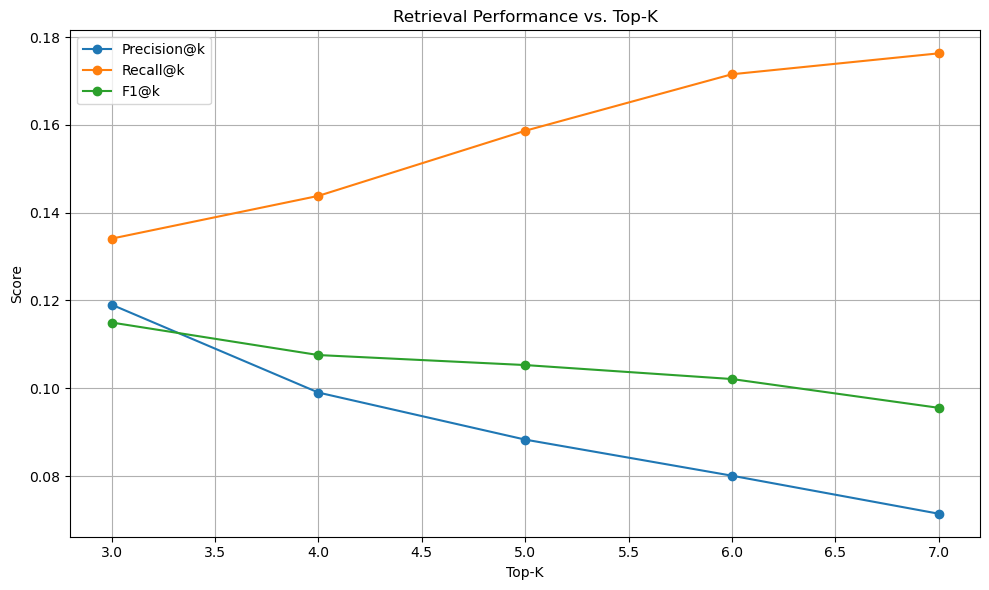

In [22]:
results = sweep_top_k_evaluation(
    claims=dev_claims,
    inverted_index=inverted_index,
    evidence_word_sets=evidence_word_sets,
    max_candidates=100000,
    k_range=range(3, 8)
)

print(results)

plot_sweep_results(results)
